# I've tried with less number of train data with 8400 images. So, counts may vary.

In [44]:
from pathlib import Path
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL

In [29]:
train_image_path = 'C:/Users/Aishwarya/Desktop/NEU/SML/project/train/train/'
my_file = Path(train_image_path)
df = pd.read_csv('C:/Users/Aishwarya/Desktop/NEU/SML/project/trainLabels.csv', delimiter=',')
df = df.query('image in {0}'.format([_.replace('.jpeg', '') for _ in os.listdir(my_file)]))

In [30]:
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255


def trim(im):
    """trim black margin, http://stackoverflow.com/questions/10615901/trim-whitespace-using-pil"""
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)


def calc_thumbnail_size(img):
    """calculate thumbnail size with constant aspect ratio"""
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
#     print(size)
    return size

def calc_crop_coords(img):
    """crop to square of desired dimension size"""
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)


def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img

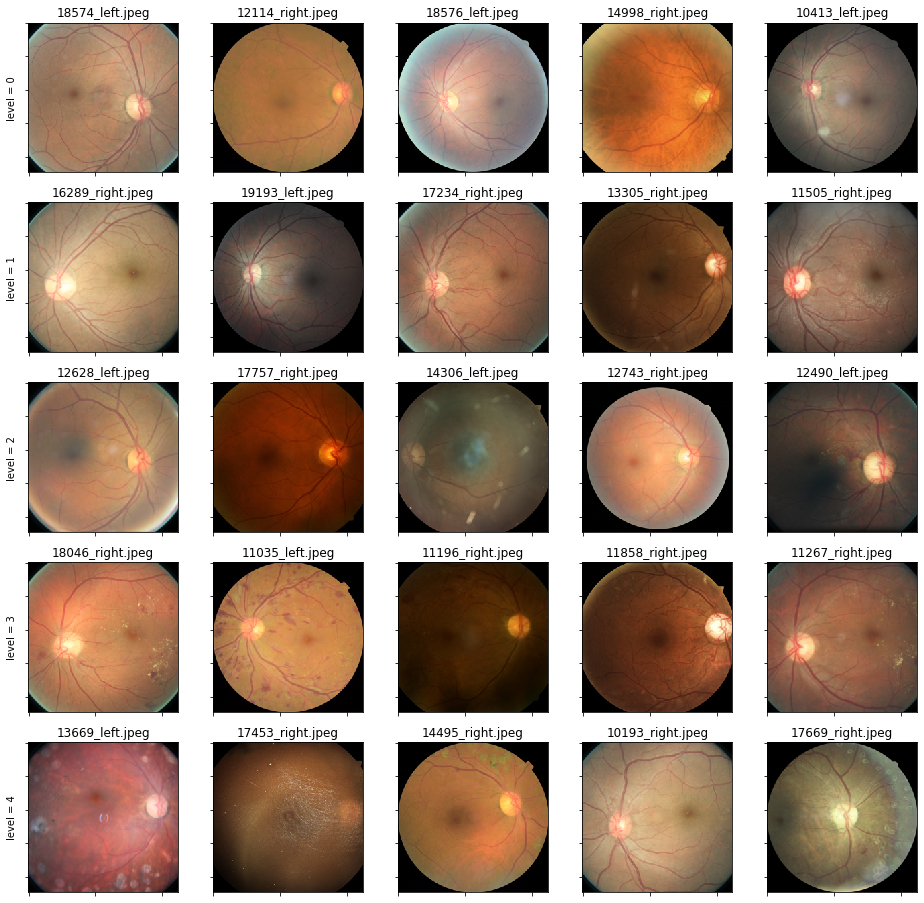

In [31]:
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255


import matplotlib.image as mpimg
imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(my_file, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
   
    im = PIL.Image.open(img)
    ax = axes[k]
    im = preprocess(im)
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))
plt.show()

# Data Augumentation

## More methods can be applied
https://software.intel.com/en-us/articles/hands-on-ai-part-14-image-data-preprocessing-and-augmentation might be helpful

In [1]:
# https://stackoverflow.com/questions/1868714/how-do-i-copy-an-entire-directory-of-files-into-an-existing-directory-using-pyth/31039095
from distutils.dir_util import copy_tree

import random
from scipy import ndarray
import skimage as sk

from skimage import transform
from skimage import util
from skimage import io

import os
import shutil

import random

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

# Creates Folders and Paths

In [3]:
main_data_folder = '../SML_Project_Data'

def clean_output_folders_augmentation(main_data_folder, disease_class, replace_folder = False):
    '''Deletes existing folder in data/train and creates a few folder for a given disease class. Outputs names of input and output folder'''

    downsized_data_path = main_data_folder + '/downsized_data'

    folder_path = downsized_data_path + '/resized_' + str(disease_class)

    print(folder_path)

    training_folder = main_data_folder + '/data/train'
    output_path = training_folder + '/resized_' + str(disease_class)

    print(output_path)

    if replace_folder:
        try:
            shutil.rmtree(output_path)
        except FileNotFoundError:
            os.mkdir(output_path)
            print('Folder does not exist, it is created', output_path, '\n')
        else:
            os.mkdir(output_path)
            print('Deleting and creating the folder at', output_path, '\n')
    
    return(folder_path, output_path)
        
#folder_path, output_path = clean_output_folders_augmentation(main_data_folder, disease_class=1, replace_folder = False)

# Counts number of files in each downsized_data_path folder to calculate target number of images to augment up to

In [4]:
downsized_data_path = main_data_folder + '/downsized_data'

original_file_count = {0 : 0,
                       1 : 0,
                       2 : 0,
                       3 : 0,
                       4 : 0}

max_file_count = 0
for disease_type in (0, 1, 2, 3, 4):
    path, dirs, files = next(os.walk(downsized_data_path + '/resized_' + str(disease_type)))
    file_count = len(files)
    if file_count > max_file_count:
        max_file_count = file_count
    print('Disease Class of', disease_type, 'has count of images of', file_count)
    original_file_count
    
    original_file_count[disease_type]  =  file_count
    
print('Maxinum count of training data to also use for augmentation', max_file_count)
#print(original_file_count)

Disease Class of 0 has count of images of 25668
Disease Class of 1 has count of images of 2301
Disease Class of 2 has count of images of 5150
Disease Class of 3 has count of images of 731
Disease Class of 4 has count of images of 566
Maxinum count of training data to also use for augmentation 25668


# Data Augmentation
## Function for Data Augmentation of One Class

In [5]:
import random
import os
from skimage import img_as_ubyte
from datetime import datetime

# our folder path containing some images
#folder_path = 'C:/Users/Aishwarya/Desktop/NEU/SML/project/data/resized_1'

def data_augmentation(folder_path, output_path, original_file_count, disease_type, max_file_count):
    '''Need a way to find the last image that was created to avoid recreating all images in the folder'''
    
    start_time = datetime.now()
    
    # Determining number of files already created
    path, dirs, files = next(os.walk(output_path))
    current_file_count = len(files)
    max_num_augmented_file_created = 0
    if current_file_count != 0:
        for file in files:
            number = file.split('_')
            number = int(number[-1].split('.')[0])
            if number > max_num_augmented_file_created:
                max_num_augmented_file_created = number
    print('Images will start after number of', max_num_augmented_file_created)
    
    final_id_files_desired = max_file_count - original_file_count.get(disease_type)

    if final_id_files_desired != 0:
        
        num_files_desired = final_id_files_desired - max_num_augmented_file_created
        
        print('Will be creating', num_files_desired, 'images for class', str(disease_type))
    
        # loop on all files of the folder and build a list of files paths
        images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        available_transformations = {
            'rotate': random_rotation,
            'noise': random_noise,
            'horizontal_flip': horizontal_flip
        }
        num_generated_files = max_num_augmented_file_created
        print('Images will start to be created at', max_num_augmented_file_created)
        
        while num_generated_files < final_id_files_desired:
            # random image from the folder
            image_path = random.choice(images)
            # read image as an two dimensional array of pixels
            try:
                image_to_transform = sk.io.imread(image_path)
            except ValueError:
                print('Value error with image', image_path, 'skipping')
            else:

                # random num of transformation to apply
                num_transformations_to_apply = random.randint(1, len(available_transformations))

                num_transformations = 0
                transformed_image = None
                while num_transformations <= num_transformations_to_apply:
                    # random transformation to apply for a single image
                    key = random.choice(list(available_transformations))
                    transformed_image = available_transformations[key](image_to_transform)
                    num_transformations += 1
                    #new_path = 'C:/Users/Aishwarya/Desktop/NEU/SML/project/data/resized_1/augmented_image_'+ str(num_generated_files) + '.jpeg'
                    new_path = output_path + '/augmented_image_'+ str(num_generated_files) + '.jpeg'

                # write image to the disk
                io.imsave(new_path,img_as_ubyte(transformed_image))
                num_generated_files += 1
        
        print(num_files_desired, 'files created for class', str(disease_type))
        print('Last image created is', new_path)
        total_time = datetime.now() - start_time
        print('To complete the script for this class took', total_time)

    else:
        print('Class of', str(disease_type), 'has the maxinum size of', max_file_count, 'already')

## Loops through each class for Data Augmentation
- 1) Creates Empty Folders
- 2) Data Augmentation and places in train folder
- 3) Moves non-augmented data into train folder

In [6]:
#0, 1, 

for disease_type in (0, 1, 2, 3, 4):
    
    folder_path, output_path = clean_output_folders_augmentation(
        main_data_folder,
        disease_class=disease_type,
        replace_folder = False)
    
    data_augmentation(
        folder_path=folder_path,
        output_path=output_path,
        original_file_count=original_file_count,
        max_file_count=max_file_count,
        disease_type = disease_type
                     )
    
    resized_image_path = downsized_data_path + '/resized_' + str(disease_type)
    print(resized_image_path)
    copy_tree(resized_image_path, output_path)
    
    

../SML_Project_Data/downsized_data/resized_2
../SML_Project_Data/data/train/resized_2
Images will start after number of 4912
Will be creating 15606 images for class 2
Images will start to be created at 4912


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_4994.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_5211.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_5282.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_7688.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_8504.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_2/augmented_image_9296.jpeg is a low c

15606 files created for class 2
Last image created is ../SML_Project_Data/data/train/resized_2/augmented_image_20517.jpeg
To complete the script for this class took 0:16:13.375129
../SML_Project_Data/downsized_data/resized_2
../SML_Project_Data/downsized_data/resized_3
../SML_Project_Data/data/train/resized_3
Images will start after number of 0
Will be creating 24937 images for class 3
Images will start to be created at 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_1782.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_2028.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_5346.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_5796.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_9167.jpeg is a low contrast image
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: ../SML_Project_Data/data/train/resized_3/augmented_image_10215.jpeg is a low 

24937 files created for class 3
Last image created is ../SML_Project_Data/data/train/resized_3/augmented_image_24936.jpeg
To complete the script for this class took 0:25:47.597438
../SML_Project_Data/downsized_data/resized_3
../SML_Project_Data/downsized_data/resized_4
../SML_Project_Data/data/train/resized_4
Images will start after number of 0
Will be creating 25102 images for class 4
Images will start to be created at 0
25102 files created for class 4
Last image created is ../SML_Project_Data/data/train/resized_4/augmented_image_25101.jpeg
To complete the script for this class took 0:25:47.440275
../SML_Project_Data/downsized_data/resized_4


# Count Training Files

In [9]:
for disease_type in (0, 1, 2, 3, 4):
    path, dirs, files = next(os.walk(main_data_folder + '/data/train/resized_' + str(disease_type)))
    file_count = len(files)
    print('Train disease class of', disease_type, 'has count of images of', file_count)

Validation disease class of 0 has count of images of 25668
Validation disease class of 1 has count of images of 25668
Validation disease class of 2 has count of images of 25668
Validation disease class of 3 has count of images of 25668
Validation disease class of 4 has count of images of 25668
